In [1]:
import cv2
import numpy as np
import h5py
import lmdb
from matplotlib import pyplot as plt
import os
import sys
import shutil
from time import time
import pickle

In [ ]:
def human_read(s):
    tt = ['','K','M','G']
    ln_len = np.log2(s) / 10
    form = int(np.floor(ln_len))
    return '{:.2f}'.format(s / (1024**form)) + tt[form]

def size(obj):
    return human_read(sys.getsizeof(obj))

def get_size(start_path = '.'):
    if os.path.isfile(start_path):
        return os.path.getsize(start_path)
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

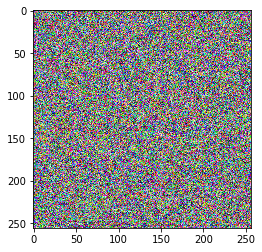

1.83G


In [3]:
N = 10000
image_data = np.random.randint(0,255,(N,256,256,3),dtype=np.uint8)

plt.imshow(image_data[0])
plt.show()

print(size(image_data))

In [4]:
class Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary 
        # for this dataset, but some datasets may include images of 
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)


In [5]:
def save_images_folder(images, N, pr=False):
    name = 'test_data'
    if os.path.isdir(name):
        shutil.rmtree(name)
    os.mkdir(name)

    start = time()
    for i in range(N):
        cv2.imwrite(os.path.join(name,'{}.png'.format(i)),image_data[i])
    td = time() - start
    size = get_size("image.lmdb")
    if pr:
        print('Execution time: ', td)
        print('Size: ', human_read(size))
    return td, size

def save_images_lmdb(images, N, pr=False):
    test_size = sys.getsizeof(image_data) + 255*2 + 8
    print(human_read(test_size))
    env = lmdb.open("image.lmdb", map_size=test_size*N*2)

    start = time()
    with env.begin(write=True) as txn:
        for i in range(N):
            value = Image(image_data[i], str(i))
            txn.put('{}'.format(i).encode("ascii"), pickle.dumps(value))
    env.close()
    td = time() - start
    size = get_size("image.lmdb")
    if pr:
        print('Execution time: ', td)
        print('Size: ', human_read(size))
    return td, size

def save_images_hdf5(images, N, pr=False):
    start = time()
    file = h5py.File("images.h5", "w")
    try:
        dataset = file.create_dataset(
            "images", np.shape(image_data), h5py.h5t.STD_U8BE, data=image_data
        )
        meta_set = file.create_dataset(
            "meta", (N,), h5py.h5t.STD_U8BE, data=np.array(range(N))
        )
    finally:
        file.close()
        
    td = time() - start
    size = get_size("images.h5")
    if pr:
        print('Execution time: ', td)
        print('Size: ', human_read(size))
    return td, size

In [6]:
def load_random_folder(n, N):
    name = 'test_data'
    start = time()
    data = np.zeros((n,256,256,3),dtype=np.uint8)
    for i in range(n):
        data[i] = cv2.imread(os.path.join(name,'{}.png'.format(np.random.randint(0,N))))
    td = time() - start
    return td, data

def load_random_lmdb(n, N):
    env = lmdb.open("image.lmdb", readonly=True)
    start = time()
    data = np.zeros((n,256,256,3),dtype=np.uint8)
    with env.begin() as txn:
        for i in range(n):
            data_pickled = txn.get('{}'.format(np.random.randint(0,N)).encode("ascii"))
            data[i] = pickle.loads(data_pickled).get_image()
    env.close()
    td = time() - start
    return td, data

def load_random_hdf5(n,N):
    file = h5py.File("images.h5", "r+")
    start = time()
    data = np.zeros((n,256,256,3),dtype=np.uint8)
    dataset = file['images']
    for i in range(n):
        data[i] = dataset[np.random.randint(0,N)]
    
    td = time() - start
    return td, data

In [7]:
def load_seq_folder(n, N):
    name = 'test_data'
    start = time()
    data = np.zeros((n,256,256,3),dtype=np.uint8)
    rg = np.random.randint(0,N-n)
    rg = np.arange(rg,rg+n,1)
    for i in range(n):
        data[i] = cv2.imread(os.path.join(name,'{}.png'.format(rg[i])))
    td = time() - start
    return td, data

def load_seq_lmdb(n, N):
    env = lmdb.open("image.lmdb", readonly=True)
    start = time()
    data = np.zeros((n,256,256,3),dtype=np.uint8)
    rg = np.random.randint(0,N-n)
    rg = np.arange(rg,rg+n,1)
    with env.begin() as txn:
        for i in range(n):
            data_pickled = txn.get('{}'.format(rg[i]).encode("ascii"))
            data[i] = pickle.loads(data_pickled).get_image()
    env.close()
    td = time() - start
    return td, data

def load_seq_hdf5(n,N):
    file = h5py.File("images.h5", "r+")
    start = time()
    data = np.zeros((n,256,256,3),dtype=np.uint8)
    dataset = file['images']
    rg = np.random.randint(0,N-n)
    rg = np.arange(rg,rg+n,1)
    data[:,:,:,:] = dataset[rg]
    
    td = time() - start
    return td, data

In [8]:
save_images_folder(image_data,N,True)
save_images_lmdb(image_data,N,True)
save_images_hdf5(image_data,N,True)

Execution time:  13.962472438812256
Size:  3.74G
1.83G
Execution time:  13.192123651504517
Size:  5.62G
Execution time:  8.187259435653687
Size:  1.83G


(8.187259435653687, 1966092048)

In [10]:
#print(load_random_folder(2000,N)[0])
print(load_random_lmdb(2000,N)[0])
print(load_random_hdf5(2000,N)[0])

0.18084287643432617
0.29030704498291016


In [11]:
#print(load_seq_folder(2000,N)[0])
print(load_seq_lmdb(2000,N)[0])
print(load_seq_hdf5(2000,N)[0])

0.14492225646972656
0.22040748596191406
